In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [18]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


fixed_size = (512, 512)
def image_loader(image_name, size=fixed_size):
    image = Image.open(image_name).convert('RGB')
    if size is not None:
        image = image.resize(size, Image.LANCZOS)
    transform = transforms.ToTensor()
    image = transform(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img_1 = image_loader("./data/vortex.jpg")
style_img_2 = image_loader("./data/picasso.jpg")
style_img_3 = image_loader("./data/galaxy.jpg")

style_images = [style_img_1, style_img_2]
# style_images = [style_img_1]
content_img = image_loader("./data/dancing.jpg")

assert style_img_1.size() == style_img_2.size() and style_img_2.size() == content_img.size(), \
    "we need to import style and content images of the same size"

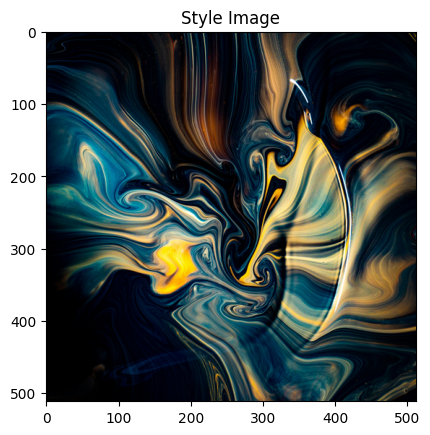

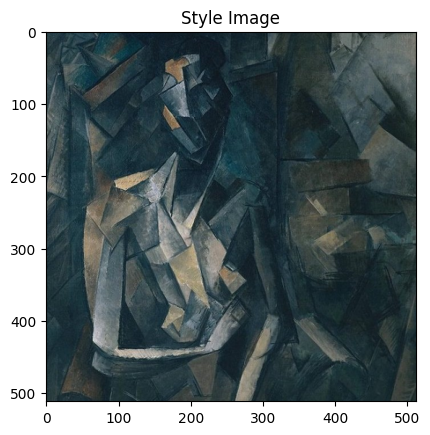

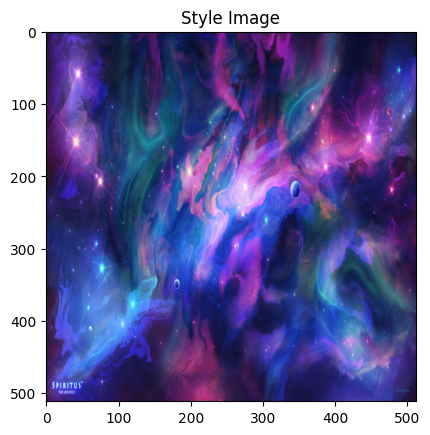

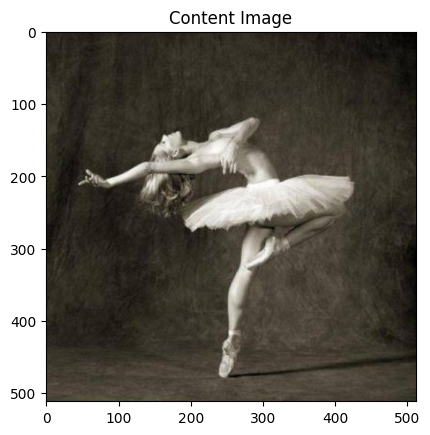

In [19]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img_1, title='Style Image')

plt.figure()
imshow(style_img_2, title='Style Image')

plt.figure()
imshow(style_img_3, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [20]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [21]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [22]:
class StyleLoss(nn.Module):
    def __init__(self, target_features, weights=[1]):
        super(StyleLoss, self).__init__()
        self.targets = []
        for target_feature in target_features:
            self.targets.append(gram_matrix(target_feature).detach())
        self.weights = weights.copy()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.targets[0]) * self.weights[0]
        for i in range(1, len(self.weights)):
            self.loss += F.mse_loss(G, self.targets[i]) * self.weights[i]
        return input

In [23]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [24]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [25]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std, content_layers,
                               style_layers, content_img, style_images, style_weights):
    
    style_weights_mod = [weight / sum(style_weights) for weight in style_weights]

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_features = []
            for j in range(len(style_images)):
                # add style loss:
                target_feature = model(style_images[j]).detach()
                target_features.append(target_feature)

        if name in style_layers:
            overall_style_loss = StyleLoss(target_features, style_weights_mod)
            model.add_module("style_loss_{}".format(i), overall_style_loss)
            style_losses.append(overall_style_loss)
                

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

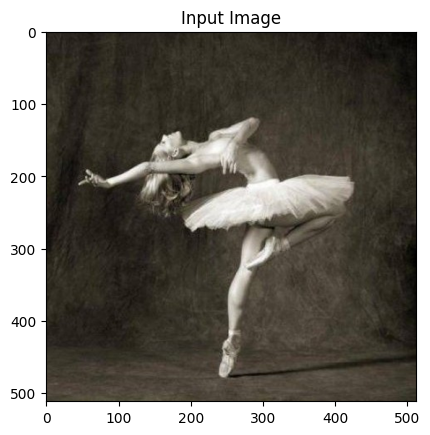

In [26]:
input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# .. code-block:: python
#
#    input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [27]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [28]:
import os

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_images, input_img, style_weights, overall_style_weight=100000, content_weight=1, num_steps=300):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, content_layers_default, style_layers_default, content_img, style_images, style_weights)
    
    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]

    # Directory to save temporary images
    temp_dir = 'temp_images'
    os.makedirs(temp_dir, exist_ok=True)

    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= overall_style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()
            
            if run[0] % 10 == 0:  # Save the image every 10 steps
                output_img = input_img.clone().detach().cpu()
                output_img = transforms.ToPILImage()(output_img[0])
                output_img.save(f'{temp_dir}/output_step_{run[0]}.png')

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)
    
    # Create a GIF from the saved images
    images = []
    for step in range(10, num_steps + 1, 1):
        img_path = f'{temp_dir}/output_step_{step}.png'
        if os.path.exists(img_path):
            images.append(Image.open(img_path))

    if images:
        images[0].save('style_transfer.gif', save_all=True, append_images=images[1:], optimize=False, duration=100, loop=0)
    
    # Cleanup temporary images
    for img_file in os.listdir(temp_dir):
        os.remove(os.path.join(temp_dir, img_file))
    os.rmdir(temp_dir)

    return input_img, "./style_transfer.gif"

Building the style transfer model..
Optimizing..


c:\Users\ASUS\Desktop\Stuff\Machine-Learning-Projects\venv\Lib\site-packages\torch\utils\_device.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


run [50]:
Style Loss : 413.957886 Content Loss: 11.814222

run [100]:
Style Loss : 410.679688 Content Loss: 10.103854

run [150]:
Style Loss : 409.915436 Content Loss: 9.664508

run [200]:
Style Loss : 409.560944 Content Loss: 9.578402

run [250]:
Style Loss : 409.564362 Content Loss: 9.698853

run [300]:
Style Loss : 409.485504 Content Loss: 9.678996



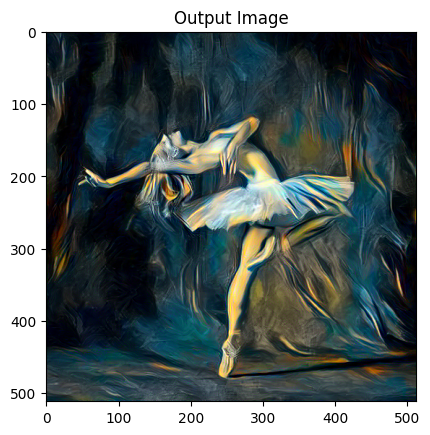

In [29]:
output_1, _ = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_images, input_img, [.5, .5])

plt.figure()
imshow(output_1, title='Output Image')
plt.ioff()
plt.show()

In [15]:
import gradio as gr
from PIL import Image
import numpy as np


def style_transfer(content_image_path, styled_images_paths):
    if content_image_path:
        content_image_tensor = image_loader(content_image_path)
    else:
        return None

    styled_images_tensors = [image_loader(image_path) for image_path in styled_images_paths]
    # content_image_pil = transforms.ToPILImage()(content_image_tensor.squeeze(0).cpu())

    weights = [1 / len(styled_images_tensors)] * len(styled_images_tensors)


    output, gif_path = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_image_tensor, styled_images_tensors, content_image_tensor.clone(), weights)
    
    output = transforms.ToPILImage()(output.squeeze(0).cpu())
    
    return output, gif_path

interface = gr.Interface(
    fn=style_transfer,
    inputs=[
        gr.Image(type='filepath', label="The main content image"),
        gr.File(file_count="multiple", label="The style images")
    ],
    outputs=[gr.Image(type='pil', label="Final Style image"), gr.Image(type='filepath', label="The transistion animation")]
)

interface.launch()


c:\Users\ASUS\Desktop\Stuff\Machine-Learning-Projects\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
